In [16]:
import pandas as pd
import folium

In [17]:
df = pd.read_csv("datasets V2AIX/df_v4.csv")

In [18]:
df_trajet = pd.read_excel("datasets V2AIX/df_trips.xlsx")

In [19]:
# Supprimer la limite d'affichage des colonnes
pd.set_option('display.max_columns', None)

df.head()

,Unnamed: 0,recording_timestamp_nsec,message_header_protocol_version,message_header_message_id,message_header_station_id_value,message_cam_generation_delta_time_value,message_cam_cam_parameters_basic_container_station_type_value,message_cam_cam_parameters_basic_container_reference_position_latitude_value,message_cam_cam_parameters_basic_container_reference_position_longitude_value,message_cam_cam_parameters_basic_container_reference_position_position_confidence_ellipse_semi_major_confidence_value,message_cam_cam_parameters_basic_container_reference_position_position_confidence_ellipse_semi_minor_confidence_value,message_cam_cam_parameters_basic_container_reference_position_position_confidence_ellipse_semi_major_orientation_value,message_cam_cam_parameters_basic_container_reference_position_altitude_altitude_value_value,message_cam_cam_parameters_basic_container_reference_position_altitude_altitude_confidence_value,message_cam_cam_parameters_high_frequency_container_choice,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_heading_heading_value_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_heading_heading_confidence_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_speed_speed_value_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_speed_speed_confidence_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_drive_direction_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_vehicle_length_vehicle_length_value_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_vehicle_length_vehicle_length_confidence_indication_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_vehicle_width_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_longitudinal_acceleration_longitudinal_acceleration_value_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_longitudinal_acceleration_longitudinal_acceleration_confidence_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_curvature_curvature_value_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_curvature_curvature_confidence_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_curvature_calculation_mode_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_yaw_rate_yaw_rate_value_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_yaw_rate_yaw_rate_confidence_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_acceleration_control_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_acceleration_control_bits_unused,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_acceleration_control_is_present,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_lane_position_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_lane_position_is_present,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_steering_wheel_angle_steering_wheel_angle_value_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_steering_wheel_angle_steering_wheel_angle_confidence_value,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_frequency_steering_wheel_angle_is_present,message_cam_cam_parameters_high_frequency_container_basic_vehicle_container_high_f

In [20]:
# df_sample = df.sample(100)
# df_sample.to_excel("df_sample.xlsx")

In [21]:
df = df.rename(columns={"message_header_station_id_value": "station_id"})

In [22]:
# On initialise le pseudonyme TLAS pour chaque véhicule (station_id)
df["pseudonym_id_tlas"] = df["station_id"].astype(str) + "_0"

# Et on crée une colonne pour signaler les périodes de silence
df["silent_period"] = False

In [23]:
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

In [24]:
import numpy as np

# Coordonnées de Aachen
aachen_lat = 50.7753
aachen_lon = 6.0839
radius_km = 5

# Conversion du rayon en degrés
lat_range = radius_km / 111
lon_range = radius_km / (111 * np.cos(np.radians(aachen_lat)))

# Filtrage des messages CAM autour d’Aachen
df = df[
    (df["latitude"].between(aachen_lat - lat_range, aachen_lat + lat_range)) &
    (df["longitude"].between(aachen_lon - lon_range, aachen_lon + lon_range))
].copy()

# Calcul surface et densité locale (si needed)
area_aachen_km2 = np.pi * radius_km**2
n_points = len(df)
print(f"Surface couverte : {area_aachen_km2:.2f} km²")
print(f"{n_points} CAMs dans un rayon de {radius_km} km autour d’Aachen.")

Surface couverte : 78.54 km²
90951 CAMs dans un rayon de 5 km autour d’Aachen.


In [25]:
from geopy.distance import geodesic
import pandas as pd
from tqdm import tqdm

def detect_stop_groups(df, speed_threshold=2, time_window=20, proximity_m=25, group_min=3):
    df = df.sort_values("timestamp").copy()
    stop_groups = []

    t_start = df["timestamp"].min()
    t_end = df["timestamp"].max()
    t = t_start

    while t < t_end:
        # Filtrage temporel
        window = df[(df["timestamp"] >= t) & (df["timestamp"] < t + pd.Timedelta(seconds=time_window))]
        slow_vehicles = window[window["speed"] <= speed_threshold]

        # Identifier les véhicules proches (en cluster)
        cluster = []
        for i, row_i in slow_vehicles.iterrows():
            lat_i, lon_i = row_i["latitude"], row_i["longitude"]
            nearby = 0
            for j, row_j in slow_vehicles.iterrows():
                if i == j:
                    continue
                lat_j, lon_j = row_j["latitude"], row_j["longitude"]
                d = geodesic((lat_i, lon_i), (lat_j, lon_j)).meters
                if d <= proximity_m:
                    nearby += 1
            if nearby >= group_min - 1:
                cluster.append(i)

        if cluster:
            stop_time = df.loc[cluster, "timestamp"].min()
            stop_groups.append(stop_time)

        t += pd.Timedelta(seconds=time_window)

    return stop_groups


In [26]:
stop_events = detect_stop_groups(df, speed_threshold=2, time_window=20, proximity_m=25, group_min=3)
print(f"Nombre d'arrêts collectifs détectés : {len(stop_events)}")

Nombre d'arrêts collectifs détectés : 1453


In [31]:
# Grouper les timestamps détectés proches les uns des autres (ex : < 60s)
def merge_close_stops(timestamps, threshold_s=60):
    timestamps = sorted(pd.to_datetime(timestamps))
    zones = []
    current = timestamps[0]

    for t in timestamps[1:]:
        if (t - current).total_seconds() > threshold_s:
            zones.append(current)
        current = t

    zones.append(current)
    return zones

zones_finales = merge_close_stops(stop_events, threshold_s=60)
print(f"Nombre approximatif de zones de feu rouge distinctes : {len(zones_finales)}")

Nombre approximatif de zones de feu rouge distinctes : 235


In [32]:
def apply_silent_zones(df, stop_times, window_s=30):
    df = df.copy()
    for t in stop_times:
        zone_start = pd.to_datetime(t)
        zone_end = zone_start + pd.Timedelta(seconds=window_s)
        mask = (df["timestamp"] >= zone_start) & (df["timestamp"] < zone_end)
        df.loc[mask, "silent_period"] = True
    return df

In [33]:
df = apply_silent_zones(df, zones_finales, window_s=30)

In [36]:
def apply_pseudonym_change_after_silence(df):
    df = df.copy()
    df = df.sort_values(["station_id", "timestamp"])
    pid_counter = {sid: 0 for sid in df["station_id"].unique()}

    for sid in df["station_id"].unique():
        last_silent = False
        for idx, row in df[df["station_id"] == sid].iterrows():
            if row["silent_period"]:
                last_silent = True
            else:
                if last_silent:
                    pid_counter[sid] += 1
                last_silent = False
                df.at[idx, "pseudonym_id_tlas"] = f"{sid}_{pid_counter[sid]}"

    return df

In [37]:
df = apply_pseudonym_change_after_silence(df)

In [ ]:
def apply_pseudonym_change_tlas(df, stop_times, window_s=30):
    df = df.copy()
    pid_counter = {sid: 1 for sid in df["station_id"].unique()}

    for t in stop_times:
        zone_end = pd.to_datetime(t) + pd.Timedelta(seconds=window_s)

        for sid in df["station_id"].unique():
            # Trouver les messages après la zone pour ce véhicule
            mask = (df["station_id"] == sid) & (df["timestamp"] >= zone_end)

            if not df[mask].empty:
                pid_counter[sid] += 1
                new_pid = f"{sid}_{pid_counter[sid]}"
                df.loc[mask, "pseudonym_id_tlas"] = new_pid

    return df

In [38]:
from geopy.distance import geodesic

# Assurer le tri par trajet et timestamp
df = df.sort_values(by=['trip_id', 'timestamp']).copy()

# Initialiser la colonne 'distance'
df['distance'] = 0.0

# Calculer la distance cumulée par trajet
for trip_id, group in df.groupby('trip_id'):
    distances = [0.0]
    coords = list(zip(group['latitude'], group['longitude']))
    for i in range(1, len(coords)):
        dist = geodesic(coords[i - 1], coords[i]).meters
        distances.append(distances[-1] + dist)
    df.loc[group.index, 'distance'] = distances

In [41]:
df['date'] = df['timestamp'].dt.date

# Agrégation par pseudonyme simulé
df_trajet_simule = df.groupby('pseudonym_id_tlas').agg({
    'timestamp': ['min', 'max'],
    'latitude': ['first', 'last'],
    'longitude': ['first', 'last'],
    'distance': 'max',
    'speed': 'mean',  # proxy si pas d'autre info de type véhicule
}).reset_index()

# Aplatir les colonnes multi-index
df_trajet_simule.columns = [
    'pseudonym_id', 'start_time', 'end_time',
    'start_latitude', 'end_latitude',
    'start_longitude', 'end_longitude',
    'distance_m', 'mean_speed'
]

# Ajout de variables dérivées
df_trajet_simule["trip_duration_seconds"] = (df_trajet_simule["end_time"] - df_trajet_simule["start_time"]).dt.total_seconds()
df_trajet_simule["trip_duration_minutes"] = df_trajet_simule["trip_duration_seconds"] / 60
df_trajet_simule["distance_km"] = df_trajet_simule["distance_m"] / 1000

# Extraire le trip_id depuis pseudonym_id (format "123456_0")
df_trajet_simule['trip_id'] = df_trajet_simule['pseudonym_id'].str.extract(r'^(\d+)_')[0].astype(int)
df_trajet_simule['trip_id'] = df_trajet_simule['trip_id'].astype(int)
df_trajet['trip_id'] = df_trajet['trip_id'].astype(int)

# Extraire station_id associé à chaque pseudonym_id_simulated
station_map = df.groupby("pseudonym_id_tlas")["station_id"].agg(lambda x: x.mode().iloc[0]).reset_index()

# Renommer pour correspondre
station_map.columns = ["pseudonym_id", "station_id"]

# Fusionner avec df_trajet_simule
df_trajet_simule = df_trajet_simule.merge(station_map, on="pseudonym_id", how="left")

# Extraire la correspondance station_id → model_id depuis df_trajet
station_to_model = df_trajet[['station_id', 'model_id']].drop_duplicates()

# Fusionner avec df_trajet_simule sur station_id
df_trajet_simule = df_trajet_simule.merge(station_to_model, on='station_id', how='left')



In [42]:
df_trajet_simule["model_id"].value_counts(dropna=False)

model_id
NaN    1022
1.0     395
2.0      84
3.0      76
6.0       9
7.0       6
4.0       5
5.0       1
Name: count, dtype: int64

In [43]:
station_simule = set(df_trajet_simule["station_id"].unique())
station_ref = set(df_trajet["station_id"].unique())

missing_stations = station_simule - station_ref
print(f"{len(missing_stations)} station_id dans df_trajet_simule ne sont pas dans df_trajet")

974 station_id dans df_trajet_simule ne sont pas dans df_trajet


In [44]:
# Nombre de station_id distincts par pseudonym_id
station_per_pseudonym = df_trajet_simule.groupby("station_id")["pseudonym_id"].nunique()

# Compter ceux qui sont associés à un seul véhicule
unique_station_count = (station_per_pseudonym == 1).sum()

# Proportion de pseudonymes associés à un seul véhicule
pourcentage_identifiants_vehicule = 100 * unique_station_count / len(station_per_pseudonym)
print("Proportion de pseudonym_id associés à un seul véhicule :", np.round(pourcentage_identifiants_vehicule, 2), "%")

Proportion de pseudonym_id associés à un seul véhicule : 89.85 %


In [45]:
# Agréger par station_id
agg_by_station = df_trajet_simule.groupby("station_id").agg({
    "distance_m": "sum",
    "pseudonym_id": "nunique"
})

# Garder seulement les véhicules ayant parcouru au total ≥ 800m
agg_by_station = agg_by_station[agg_by_station["distance_m"] >= 800]

# Calculer proportion de ceux qui ont eu un seul pseudonyme
proportion = 100 * (agg_by_station["pseudonym_id"] == 1).sum() / len(agg_by_station)
print("Proportion de véhicules avec un seul pseudonym_id (≥800m cumulés) :", np.round(proportion, 2), "%")

Proportion de véhicules avec un seul pseudonym_id (≥800m cumulés) : 12.5 %


In [46]:
# Garder seulement les véhicules ayant parcouru au total ≥ 1500m
agg_by_station = agg_by_station[agg_by_station["distance_m"] >= 1500]

# Calculer proportion de ceux qui ont eu un seul pseudonyme
proportion = 100 * (agg_by_station["pseudonym_id"] == 1).sum() / len(agg_by_station)
print("Proportion de véhicules avec un seul pseudonym_id (≥1500m cumulés) :", np.round(proportion, 2), "%")

Proportion de véhicules avec un seul pseudonym_id (≥1500m cumulés) : 50.0 %


In [47]:
df_trajet_simule = df_trajet_simule.sort_values("start_time").reset_index(drop=True)
df_trajet_simule["segment_index"] = df_trajet_simule.index

In [48]:
import numpy as np

def compute_bearing(lat1, lon1, lat2, lon2):
    # Calcul de la direction entre deux points (en degrés)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1

    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))
    bearing = np.degrees(np.arctan2(x, y))
    return (bearing + 360) % 360

# Appliquer sur le DataFrame
df_trajet_simule["direction"] = compute_bearing(
    df_trajet_simule["start_latitude"],
    df_trajet_simule["start_longitude"],
    df_trajet_simule["end_latitude"],
    df_trajet_simule["end_longitude"]
)

# Pour compatibilité avec l'algo
df_trajet_simule["start_direction"] = df_trajet_simule["direction"]
df_trajet_simule["end_direction"] = df_trajet_simule["direction"]


Relinking Naïf

In [49]:
from geopy.distance import geodesic

def relinking_score(row_A, row_B):
    # Distance en mètres entre la fin de A et le début de B
    spatial_dist = geodesic(
        (row_A["end_latitude"], row_A["end_longitude"]),
        (row_B["start_latitude"], row_B["start_longitude"])
    ).meters

    # Temps écoulé en secondes entre A et B
    temporal_gap = (row_B["start_time"] - row_A["end_time"]).total_seconds()

    # Score combiné (plus bas = plus probable)
    # pondération arbitraire : 1 mètre ≈ 1 seconde ici
    if temporal_gap < 0 or temporal_gap > 600:  # exclusion >10 min ou B commence avant A se termine
        return np.inf

    return spatial_dist + temporal_gap  # ou une pondération personnalisée


In [50]:
best_links = []

for i, row_A in df_trajet_simule.iterrows():
    candidates = df_trajet_simule[df_trajet_simule["start_time"] > row_A["end_time"]]
    
    best_score = np.inf
    best_match_id = None
    
    for _, row_B in candidates.iterrows():
        score = relinking_score(row_A, row_B)
        if score < best_score:
            best_score = score
            best_match_id = row_B["pseudonym_id"]
    
    if best_match_id is not None:
        best_links.append({
            "source": row_A["pseudonym_id"],
            "target": best_match_id,
            "score": best_score
        })

In [51]:
df_links = pd.DataFrame(best_links)

In [52]:
from collections import defaultdict

# Créer un graphe orienté : source → target
link_dict = dict(zip(df_links["source"], df_links["target"]))

# Stocker les chaînes reconstruites
chains = []
visited = set()

for source in link_dict:
    if source in visited:
        continue

    chain = [source]
    visited.add(source)
    current = source

    while current in link_dict:
        next_pseudo = link_dict[current]
        if next_pseudo in visited or next_pseudo == current:
            break
        chain.append(next_pseudo)
        visited.add(next_pseudo)
        current = next_pseudo

    chains.append(chain)


In [53]:
reconstructed_trip_map = {}
for i, chain in enumerate(chains):
    for pseudo_id in chain:
        reconstructed_trip_map[pseudo_id] = f"retrip_{i}"


In [54]:
df_eval = df_trajet_simule[["pseudonym_id", "trip_id"]].copy()
df_eval["retrip_id"] = df_eval["pseudonym_id"].map(reconstructed_trip_map)

In [55]:
# Pour chaque trip_id, combien de retrip_id différents ?
trip_fragmentation = df_eval.groupby("trip_id")["retrip_id"].nunique()

# Pourcentage de trip_id qui ont été entièrement reconstitués
nb_reconstitués = (trip_fragmentation == 1).sum()
pourcentage = 100 * nb_reconstitués / len(trip_fragmentation)

print(f"Réidentification complète de trajets : {pourcentage:.2f}%")

Réidentification complète de trajets : 94.51%


In [56]:
# Vraies paires successives dans le même trip_id
true_links = []

df_sorted = df_trajet_simule.sort_values(["trip_id", "start_time"])

for _, group in df_sorted.groupby("trip_id"):
    pseudos = group["pseudonym_id"].tolist()
    true_links.extend([(pseudos[i], pseudos[i+1]) for i in range(len(pseudos)-1)])


In [57]:
pred_links = list(zip(df_links["source"], df_links["target"]))

In [58]:
true_set = set(true_links)
pred_set = set(pred_links)

tp = len(true_set & pred_set)  # vrais positifs : GPA a bien relié deux segments du même trip_id
fp = len(pred_set - true_set)  # faux positifs : GPA a relié deux pseudonymes de trip_ids différents
fn = len(true_set - pred_set)  # faux négatifs : GPA a raté un lien réel

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
idf1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Relinking (pairwise):")
print(f"Precision : {precision:.2%}")
print(f"Recall    : {recall:.2%}")
print(f"IDF1      : {idf1:.2%}")

Relinking (pairwise):
Precision : 7.00%
Recall    : 69.81%
IDF1      : 12.72%


Relinking Seuil

In [59]:
def relinking_score(row_A, row_B, time_limit=30, distance_limit=1500):
    # Distance en mètres
    spatial_dist = geodesic(
        (row_A["end_latitude"], row_A["end_longitude"]),
        (row_B["start_latitude"], row_B["start_longitude"])
    ).meters

    # Temps écoulé en secondes
    temporal_gap = (row_B["start_time"] - row_A["end_time"]).total_seconds()

    # Rejeter si contraintes non respectées
    if temporal_gap < 0 or temporal_gap > time_limit or spatial_dist > distance_limit:
        return np.inf

    # Score combiné (on peut ajuster la pondération)
    return spatial_dist + temporal_gap


In [60]:
best_links = []

for i, row_A in df_trajet_simule.iterrows():
    candidates = df_trajet_simule[df_trajet_simule["start_time"] > row_A["end_time"]]

    best_score = np.inf
    best_match_id = None

    for _, row_B in candidates.iterrows():
        score = relinking_score(row_A, row_B)
        if score < best_score:
            best_score = score
            best_match_id = row_B["pseudonym_id"]

    if best_score < np.inf:
        best_links.append({
            "source": row_A["pseudonym_id"],
            "target": best_match_id,
            "score": best_score
        })


In [61]:
df_links = pd.DataFrame(best_links)

In [62]:
from collections import defaultdict

# Créer un graphe orienté : source → target
link_dict = dict(zip(df_links["source"], df_links["target"]))

# Stocker les chaînes reconstruites
chains = []
visited = set()

for source in link_dict:
    if source in visited:
        continue

    chain = [source]
    visited.add(source)
    current = source

    while current in link_dict:
        next_pseudo = link_dict[current]
        if next_pseudo in visited or next_pseudo == current:
            break
        chain.append(next_pseudo)
        visited.add(next_pseudo)
        current = next_pseudo

    chains.append(chain)


In [63]:
reconstructed_trip_map = {}
for i, chain in enumerate(chains):
    for pseudo_id in chain:
        reconstructed_trip_map[pseudo_id] = f"retrip_{i}"


In [64]:
df_eval = df_trajet_simule[["pseudonym_id", "trip_id"]].copy()
df_eval["retrip_id"] = df_eval["pseudonym_id"].map(reconstructed_trip_map)

In [65]:
# Pour chaque trip_id, combien de retrip_id différents ?
trip_fragmentation = df_eval.groupby("trip_id")["retrip_id"].nunique()

# Pourcentage de trip_id qui ont été entièrement reconstitués
nb_reconstitués = (trip_fragmentation == 1).sum()
pourcentage = 100 * nb_reconstitués / len(trip_fragmentation)

print(f"Réidentification complète de trajets : {pourcentage:.2f}%")

Réidentification complète de trajets : 64.49%


In [66]:
# Vraies paires successives dans le même trip_id
true_links = []

df_sorted = df_trajet_simule.sort_values(["trip_id", "start_time"])

for _, group in df_sorted.groupby("trip_id"):
    pseudos = group["pseudonym_id"].tolist()
    true_links.extend([(pseudos[i], pseudos[i+1]) for i in range(len(pseudos)-1)])


In [67]:
pred_links = list(zip(df_links["source"], df_links["target"]))

In [68]:
true_set = set(true_links)
pred_set = set(pred_links)

tp = len(true_set & pred_set)  # vrais positifs : GPA a bien relié deux segments du même trip_id
fp = len(pred_set - true_set)  # faux positifs : GPA a relié deux pseudonymes de trip_ids différents
fn = len(true_set - pred_set)  # faux négatifs : GPA a raté un lien réel

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
idf1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Relinking (pairwise):")
print(f"Precision : {precision:.2%}")
print(f"Recall    : {recall:.2%}")
print(f"IDF1      : {idf1:.2%}")

Relinking (pairwise):
Precision : 12.91%
Recall    : 64.78%
IDF1      : 21.53%


Relinking prudent

In [69]:
from geopy.distance import geodesic

def relinking_score(row_A, row_B, time_limit=30, distance_limit=1500):
    # Spatio-temporel
    spatial_dist = geodesic(
        (row_A["end_latitude"], row_A["end_longitude"]),
        (row_B["start_latitude"], row_B["start_longitude"])
    ).meters
    temporal_gap = (row_B["start_time"] - row_A["end_time"]).total_seconds()

    if temporal_gap < 0 or temporal_gap > time_limit or spatial_dist > distance_limit:
        return np.inf  # Hors limite

    # Optionnels mais utiles : vitesse et direction
    speed_diff = abs(row_A["mean_speed"] - row_B["mean_speed"])
    direction_diff = abs((row_A["end_direction"] - row_B["start_direction"] + 180) % 360 - 180)

    # Bonus si modèle identique
    model_bonus = 0 if row_A["model_id"] == row_B["model_id"] else 200  # pénalité légère

    # Score pondéré (ajustable)
    score = spatial_dist + 2 * temporal_gap + 5 * speed_diff + 3 * direction_diff + model_bonus
    return score



In [70]:
best_links = []

for i, row_A in df_trajet_simule.iterrows():
    # Chercher les 5 suivants dans le temps
    candidates = df_trajet_simule[df_trajet_simule["start_time"] > row_A["end_time"]]
    candidates = candidates.nsmallest(5, "start_time")  # seulement 5 plus proches

    best_score = np.inf
    best_match_id = None

    for _, row_B in candidates.iterrows():
        score = relinking_score(row_A, row_B)
        if score < best_score:
            best_score = score
            best_match_id = row_B["pseudonym_id"]

    # On accepte le lien seulement s’il a un score réaliste (ex: < 1000)
    if best_score < 100:
        best_links.append({
            "source": row_A["pseudonym_id"],
            "target": best_match_id,
            "score": best_score
        })


In [71]:
df_links = pd.DataFrame(best_links)

In [72]:
from collections import defaultdict

# Créer un graphe orienté : source → target
link_dict = dict(zip(df_links["source"], df_links["target"]))

# Stocker les chaînes reconstruites
chains = []
visited = set()

for source in link_dict:
    if source in visited:
        continue

    chain = [source]
    visited.add(source)
    current = source

    while current in link_dict:
        next_pseudo = link_dict[current]
        if next_pseudo in visited or next_pseudo == current:
            break
        chain.append(next_pseudo)
        visited.add(next_pseudo)
        current = next_pseudo

    chains.append(chain)


In [73]:
reconstructed_trip_map = {}
for i, chain in enumerate(chains):
    for pseudo_id in chain:
        reconstructed_trip_map[pseudo_id] = f"retrip_{i}"


In [74]:
df_eval = df_trajet_simule[["pseudonym_id", "trip_id"]].copy()
df_eval["retrip_id"] = df_eval["pseudonym_id"].map(reconstructed_trip_map)

In [75]:
# Pour chaque trip_id, combien de retrip_id différents ?
trip_fragmentation = df_eval.groupby("trip_id")["retrip_id"].nunique()

# Pourcentage de trip_id qui ont été entièrement reconstitués
nb_reconstitués = (trip_fragmentation == 1).sum()
pourcentage = 100 * nb_reconstitués / len(trip_fragmentation)

print(f"Réidentification complète de trajets : {pourcentage:.2f}%")

Réidentification complète de trajets : 2.78%


In [76]:
# Vraies paires successives dans le même trip_id
true_links = []

df_sorted = df_trajet_simule.sort_values(["trip_id", "start_time"])

for _, group in df_sorted.groupby("trip_id"):
    pseudos = group["pseudonym_id"].tolist()
    true_links.extend([(pseudos[i], pseudos[i+1]) for i in range(len(pseudos)-1)])


In [77]:
pred_links = list(zip(df_links["source"], df_links["target"]))

In [78]:
true_set = set(true_links)
pred_set = set(pred_links)

tp = len(true_set & pred_set)  # vrais positifs : GPA a bien relié deux segments du même trip_id
fp = len(pred_set - true_set)  # faux positifs : GPA a relié deux pseudonymes de trip_ids différents
fn = len(true_set - pred_set)  # faux négatifs : GPA a raté un lien réel

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
idf1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Relinking (pairwise):")
print(f"Precision : {precision:.2%}")
print(f"Recall    : {recall:.2%}")
print(f"IDF1      : {idf1:.2%}")

Relinking (pairwise):
Precision : 89.19%
Recall    : 20.75%
IDF1      : 33.67%


In [79]:
df_relinking = pd.DataFrame({
    "Schéma": [
        "V2AIX (raw)",
        "ETSI-compliant",
        "BEAT-Traffic",
        "CAPS",
        "CADS"
    ],
    "Taux de relinking (%)": [
        100.0,
        42.3,   # ← exemple, à remplacer par ta vraie mesure
        25.7,   # ← à ajouter plus tard
        12.8,   # ← hypothétique
        7.4     # ← hypothétique
    ]
})

C:\Users\vi.carpentier\AppData\Local\Temp\ipykernel_10164\3775015466.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_relinking, x="Schéma", y="Taux de relinking (%)", palette="viridis")


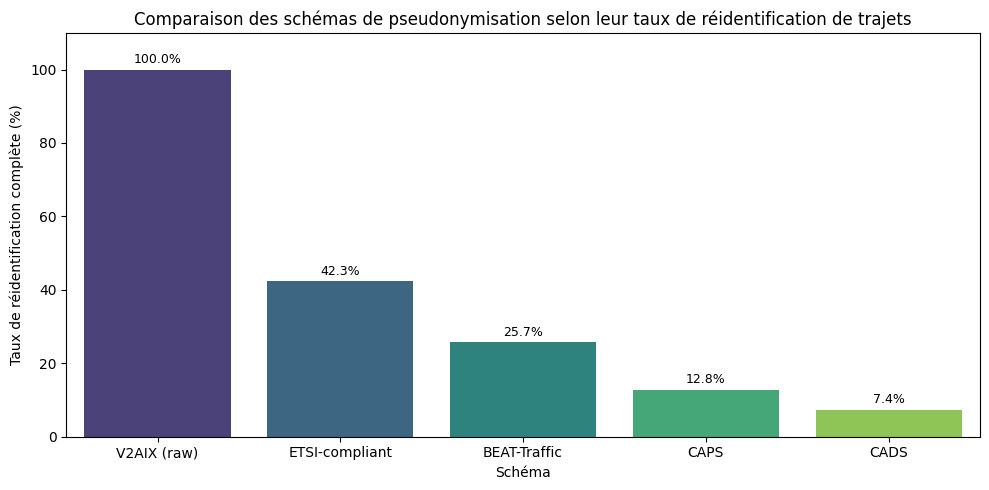

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# Trier par score décroissant
df_relinking = df_relinking.sort_values("Taux de relinking (%)", ascending=False)

# Affichage
plt.figure(figsize=(10, 5))
sns.barplot(data=df_relinking, x="Schéma", y="Taux de relinking (%)", palette="viridis")

# Ajouter les labels
for index, row in df_relinking.iterrows():
    plt.text(index, row["Taux de relinking (%)"] + 1, f"{row['Taux de relinking (%)']:.1f}%", 
             ha='center', va='bottom', fontsize=9)

plt.title("Comparaison des schémas de pseudonymisation selon leur taux de réidentification de trajets")
plt.ylabel("Taux de réidentification complète (%)")
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0)
plt.tight_layout()
plt.show()